<a href="https://colab.research.google.com/github/a-forty-two/cylons/blob/master/07_Deep_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
# https://archive.ics.uci.edu/ml/datasets/auto+mpg
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow import keras

TensorFlow 1.x selected.
1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
filepath = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data = keras.utils.get_file('auto-mpg.data', filepath)
print(data)
!ls '/root/.keras/datasets/'
# wget also -> we could download public data (only on linux command line)

/root/.keras/datasets/auto-mpg.data
auto-mpg.data


multi-valued discrete -> Categorical

continuous -> can be used for regression 

NaN, NaT -> Not a number, not a time 

pd.drop_na takes care of all types of NA 


In [10]:
# !cat '/root/.keras/datasets/auto-mpg.data'
col_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'model_year', 'origin', 'car_name']
# now we are aware that these are TSV (tab-sep) and not simple CSVs
fl = pd.read_csv(data, names=col_names, sep=' ', comment='\t', na_values='?', skipinitialspace=True)
fl.head()
fl['car_name']
data = fl.iloc[:,:-1] # skipping car names are this is useless data for us (CORRELATION TEST, HEATMAP)
data.head() 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [11]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [12]:
# REPLACE MISSING VALUES -> cloud computing in week 3
# Read cleaning modes on https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data
# Dropping them is another way
df = data.dropna()
df.isna().sum()



mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [14]:
df.head(20)

# Y is MPG , rest Cylinders to origin is X 
df.origin.value_counts()
# Assume -> origin was city name converted to numbers (ENCODING)
# 1-> BOM, 2-> BLR, 3-> MAA 
# WE are trying to calculate MILES-PER-GALLON 


1    245
3     79
2     68
Name: origin, dtype: int64

In [15]:
df.head()
# mpg = w1*cylinders + w2*displacement + w3*hp ... does this mean that model_year and origin 
# were mathematical in nature? ABSOLUTELY NOT!!! 

# WHENVER INDEPENDET CATEGORIES are present -> Origin is BLR independent of origin in BOM
# INDEPENDENT, DISTINCT VALUES
# In such a scenario -> DOES it mean -> 
# y = w * city + bias 
# does it mean that if city_blr was 1, and city_bom was 2, then BOM is twice of BLR?
# THIS IS NOT A VALID RELATIONSHIP! 
# IN such a scenrio-> we apply One-Hot-Encoding 
# this encoding creates NEW columns for every city -> SUCH that the city that is useful
# is set to 1, and others to 0 
# BOM MAA BLR
#   0   1   0    -> this means that w1*BOM + w2*MAA + w3*BLR -> w1*0 + w2*MAA + w3*0
# hence only Chennai's weight would have survived! OTHER CITIES' weights would have become 0!
# thus giving a ML equation much better suited for individual city-level prediction 





,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [16]:
# why was cylinder not one-hot-encoded?
# because there is a math relationship -> more the pistons, lesser the MPG

df.model_year.value_counts() # TOO many value 
# what could be done model_year? WE don't know-> try out multiple things
# 1) IGNORE and 2) consider it as it is
# M gives behavior1 in first case, and behavior2 in 2nd case. Pick whatever gave better metrics!


73    40
78    36
76    34
82    30
75    30
79    29
70    29
81    28
77    28
72    28
80    27
71    27
74    26
Name: model_year, dtype: int64

Cylinders -> keeping them as it is

displacement, horsepower	weight,acceleration -> continuous, keep it as it is

origin -> NOT FOLLOWING any empirical or mathematical relations, and CATEGORICAL in nature, HENCE one-hot-encoded 

model_year	-> use it in 2 ways,1) keep it as it is and 2) drop. Pick the better model as per outputs!

In [19]:
# ONE HOT ENCODING PROCESS 
origins = df.pop('origin')
# based on this pop, we can create new columns
df['BLR'] = (origins==1)*1 # TRUE *1 = 1 
df['MAA'] = (origins==2)*1
df['BOM'] = (origins==3)*1

df.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,BLR,MAA,BOM
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [20]:
df.tail()
# 394 was supposed to be data for Chennai. Now weight_BLR and weight_BOM will be multiplied to 0
# for this row! hence prediction will be stronger for just weight_MAA 
# Hence, better weights will be learnt 

# ONE HOT ENCODED COLUMNS can be used for filtering also! 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,BLR,MAA,BOM
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [25]:
(origins==2)*1

0      0
1      0
2      0
3      0
4      0
      ..
393    0
394    1
395    0
396    0
397    0
Name: origin, Length: 392, dtype: int64

In [0]:
# train_test_split function -> in most cases 
# SAMPLING -> based on interval, based on events 

traindata = df.sample(frac=0.75, random_state=42)
testdata = df.drop(traindata.index)



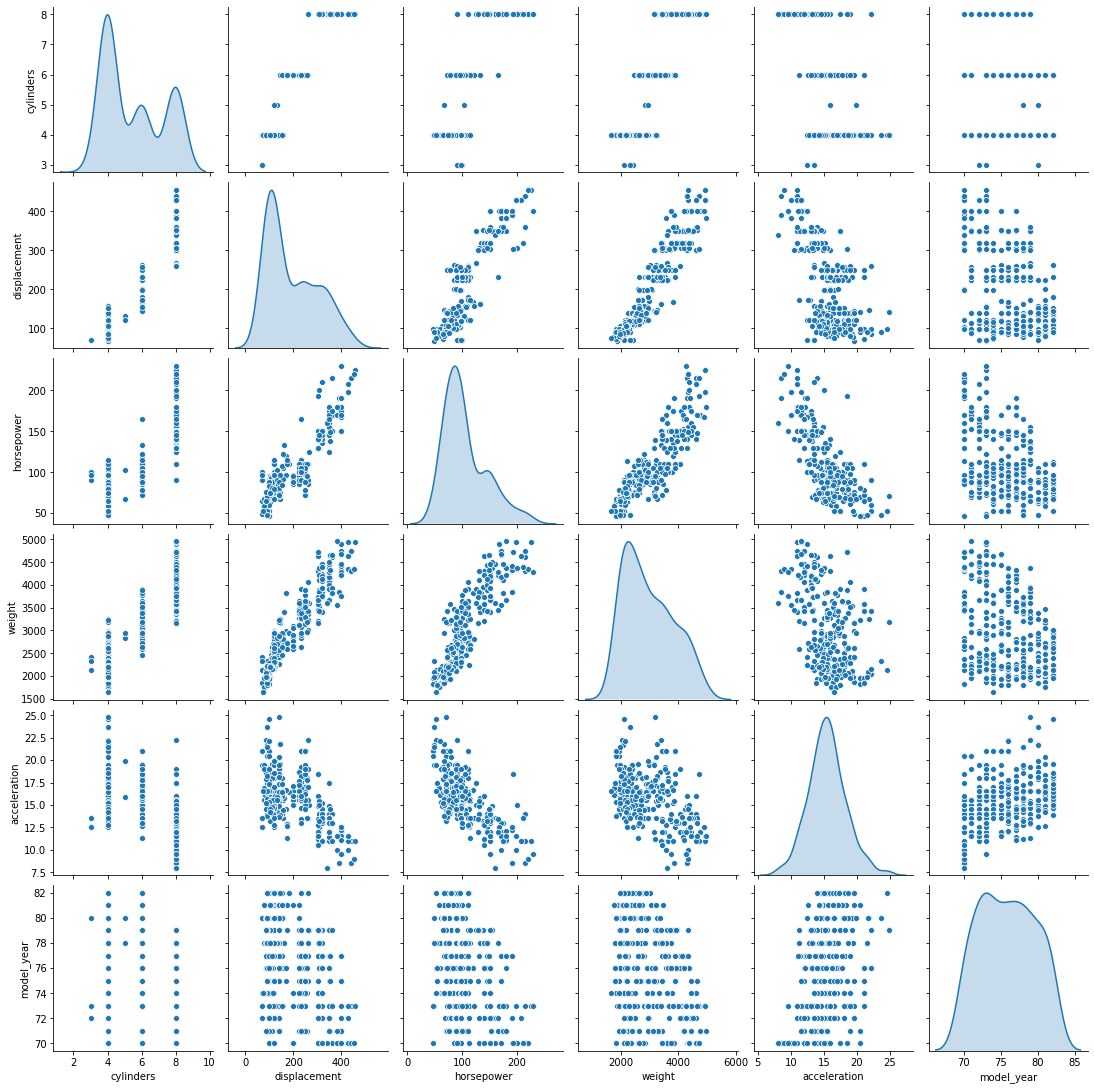

Index(['cylinders', 'displacement', 'horsepower', 'weight'], dtype='object')

In [34]:
myfeatures = traindata.columns[1:-3] # from cylinders till model_year
sns.pairplot(traindata[myfeatures], diag_kind='kde')
plt.show()
# MODEL year -> ALL OVER THE PLACE, no clear boundaries could be used 
myfeatures = myfeatures[:-2]
myfeatures

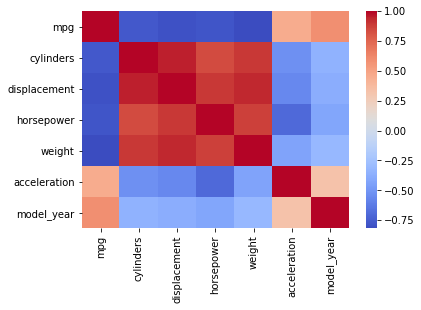

In [33]:
#df.cylinders.value_counts()
corrs = traindata.iloc[:,:-3].corr()
sns.heatmap(corrs, cmap='coolwarm')
# y-> MPG
# x-> Cylinders, Displacement, Horsepower, weight 
# to ignore -> Acceleration, model_year
# WHY? ACCELEARATION and MODEL_YEAR are only related to each other and that too WEAKLY

In [36]:
myfeatures = traindata.columns[1:-5]
myfeatures

Index(['cylinders', 'displacement', 'horsepower', 'weight'], dtype='object')

In [0]:
ytrain = traindata.pop('mpg')
ytest = testdata.pop('mpg')
xtrain = traindata[myfeatures]
xtest = testdata[myfeatures]

In [38]:
xtest.head()
# BECAUSE our data is not normalized, any neural_weight multiplied to feature_weight 
# would become a very large number-> THUS equation will be biased towards WEIGHT column!

# DATA NORMALIZATION -> Z-Score 

,cylinders,displacement,horsepower,weight
1,8,350.0,165.0,3693.0
8,8,455.0,225.0,4425.0
13,8,455.0,225.0,3086.0
14,4,113.0,95.0,2372.0
20,4,110.0,87.0,2672.0


In [0]:
# Z-Score -> till now we applied Z-Score to entire dataset and then did test/train split

# but in this case, we have first SPLIT! 
# If data was truly together, then MU and SIGMA from training set should have made some
# sense in testing set also. 
# At the very least, you are APPLying the same rules of training normalization into testing norm

# POINT-> USE the same values of TRAIN-MU and TRAIN-SIGMA for test also! 

In [39]:
stats = xtrain.describe().T
mu = stats['mean']
sigma = stats['std']
# z-score formula -> norm_data = (x-mu) / sigma
xtrain_norm = (xtrain-mu)/sigma
xtest_norm = (xtest-mu)/sigma 
xtest_norm.head()
# NOW you can see OUTLIERS wrt TRAINING data, that would have been OTHERWISE ignored 

,cylinders,displacement,horsepower,weight
1,1.450642,1.460190,1.517087,0.829423
8,1.450642,2.455653,3.042823,1.690548
13,1.450642,2.455653,3.042823,0.115347
14,-0.876718,-0.786713,-0.262939,-0.724603
20,-0.876718,-0.815154,-0.466370,-0.371683


In [0]:
# OBJECTIVE ->  mpg = w1*cylinders+ w2*displacement+ w3*horsepower+ w4*weight + bias
# MACHINE LEARNING -> but that relationship may not be so easy as above
# HENCE we take help deep learning -> BREAK Cylin, disp... weight into even smaller features!

# Dense(ReLU)->Dense(ReLU)->Dense(ReLU)
# what if the model above doesn't work?
# 1) INcrease HP_dim_l1_l2 and HP_dim_l2_l3
# 2) MAKE MODEL DEEPER -> introduce one more Dense(ReLU) layer!
# More dense layers you add -> more are the chances of OVERFITTING 

# ONCE A NN is created, it cannot be changed! NN is HARDCODED! 
# Teach NN to do X * Y -> it cannot LEARN X * Y * Z 

In [0]:
HP_epoch = 1000
HP_dim_l1_l2_firstModel = 64
HP_dim_l2_l3_firstModel = 128
HP_lr_firstModel = 1e-3 # 0.001

HP_dim_l1_l2_secModel = 64
HP_dim_l2_l3_secModel = 256
HP_lr_secModel = 1e-3 # 0.01
# two sets of HP to build and compare 2 diff models 

# LR impacts the OPTIMIZER and LOSS functions, which in turn adjust our weights
opt1 = tf.keras.optimizers.RMSprop(HP_lr_firstModel)
opt2 = tf.keras.optimizers.RMSprop(HP_lr_secModel)

In [0]:
# First Model
m1 = keras.Sequential()
m1.add(keras.layers.Dense(HP_dim_l1_l2_firstModel, activation=tf.nn.relu,input_shape=[len(xtrain.keys())]))
m1.add(keras.layers.Dense(HP_dim_l2_l3_firstModel, activation=tf.nn.relu))
m1.add(keras.layers.Dense(1, activation= tf.nn.relu))
m1.compile(optimizer=opt1, loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])


# INPUT_SHAPE -> NO LAYER EXCEPT INPUT LAYER can control input size
# ALL OTHER NN LAYERS HAVE TO TAKE EVERYTHING THAT PREVIOUS LAYER IS SENDING THEM


In [0]:
m2 = keras.Sequential()
m2.add(keras.layers.Dense(HP_dim_l1_l2_secModel, activation=tf.nn.relu,input_shape=[len(xtrain.keys())]))
m2.add(keras.layers.Dense(HP_dim_l2_l3_secModel, activation=tf.nn.relu))
m2.add(keras.layers.Dense(1, activation= tf.nn.relu))
m2.compile(optimizer=opt2, loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])



In [50]:
m1.summary() 
# 64 X 128 + 128
# 128 X 1 + 1

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [51]:
m2.summary()
# 64 X 256 + 256
# 256 X 1 + 1

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________
